In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_SILENT"] = "true"

In [2]:
import argparse
import copy
import json
import os
import statistics
from pathlib import Path

import numpy as np
import pandas as pd
import src.influence as inf_utils
import torch
import yaml
from src import BertClassifier
from src import datasets as data_utils
from src import influence, train_utils, utils
from src.datasets import create_loo_dataset, create_test_sst2, create_train_sst2
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

import wandb

device = utils.get_device()

## Original Model

In [5]:
TRAIN_MODEL = False

if TRAIN_MODEL:
    # Load config
    config = utils.load_config(
        "results_10k_l2/bert-classifier-epoch5-10000-l2.yaml",
        classifier_init_state_path="model_params/init_classifier_params.pt",
        epochs=20,
        num_training_examples=10000,
        optimizer_weight_decay=0.001,
    )

    # Create datasets
    train_dataset = create_train_sst2(
        num_samples=config["num_training_examples"],
        tokenizer_name=config["bert_model_name"],
        max_seq_len=config["max_sequence_length"],
        device=device,
    )

    test_dataset = create_test_sst2(
        tokenizer_name=config["bert_model_name"],
        max_seq_len=config["max_sequence_length"],
        device=device,
    )
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

    # Train model
    og_model, fdf, test_loss, test_acc = train_utils.train_bert_model(
        train_dataset, test_dataset, config
    )
else:
    # Load model and config
    og_model, config = BertClassifier.load_model(
        "model_params/bert-best.yaml"
    )

    # Create datasets
    train_dataset = create_train_sst2(
        num_samples=config["num_training_examples"],
        tokenizer_name=config["bert_model_name"],
        max_seq_len=config["max_sequence_length"],
        device=device,
    )

    test_dataset = create_test_sst2(
        tokenizer_name=config["bert_model_name"],
        max_seq_len=config["max_sequence_length"],
        device=device,
    )
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

    # Get test loss
    fdf, test_loss, test_acc = train_utils.evaluate_loss(og_model, test_dataloader)

print((test_loss, test_acc))
config

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 9996.51it/s]


(0.39863892992381156, 83.14220183486239)


{'batch_size': 32,
 'bert_model_name': 'distilbert-base-uncased',
 'classifier_drop_out': 0,
 'classifier_hidden_size': 0,
 'classifier_init_state_path': 'model_params/bert-epoch9-reg0.001-10000.pt',
 'classifier_type': 'single-fc',
 'epochs': 9,
 'learning_rate': 0.0002,
 'max_sequence_length': 64,
 'num_training_examples': 10000,
 'optimizer_weight_decay': 0.001}

In [6]:
# correct_fdf = fdf[fdf.pred == fdf.label]
# correct_fdf.sort_values("loss", ascending=False).iloc[:5]

fdf.sort_values("loss", ascending=False).iloc[:5]

,test_guid,logits,pred,label,loss
862,862,"[-2.1770434, 2.074576]",1,0,4.265760
218,218,"[-2.1095824, 1.6889799]",1,0,3.820718
544,544,"[-2.088636, 1.667077]",1,0,3.778827
528,528,"[1.3089001, -1.6915847]",0,1,3.049049
494,494,"[-1.5574929, 1.2966905]",1,0,2.910188


## Choose LOO points based on influence

In [7]:
def create_infl_df(infl, test_guid):
    idf = pd.DataFrame(data=infl, index=range(len(infl)), columns=["influence"])
    idf = idf.rename_axis("train_guid").reset_index()
    idf["test_guid"] = TEST_GUID
    return idf

In [11]:
from src import influence

# TEST_GUID = 334
# TEST_GUID = 315

# Good results
# TEST_GUID = 862

TEST_GUID = 218
DAMPING_TERM = 5e-3
LISSA_DEPTH = 0.2
COMPUTE_INFLUENCE = True


if COMPUTE_INFLUENCE:
    param_infl = list(og_model.classifier.parameters())
    infl = influence.compute_influence(
        full_model=og_model,
        test_guid=TEST_GUID,
        param_influence=param_infl,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        lissa_r=1,
        lissa_depth=LISSA_DEPTH,
        damping=DAMPING_TERM,
        scale=100,
    )
    idf = create_infl_df(infl, TEST_GUID)
else:
    idf = pd.read_csv(f"results_10k_reg001/influence/influence-testguid-{TEST_GUID}.csv")

LiSSA reps: 1 and num_iterations: 3000
Recursion at depth 0: norm is 27.419552
Recursion at depth 100: norm is 322.938171
Recursion at depth 200: norm is 497.823730
Recursion at depth 300: norm is 599.487610
Recursion at depth 400: norm is 660.190430
Recursion at depth 500: norm is 692.897583
Recursion at depth 600: norm is 713.361572
Recursion at depth 700: norm is 726.410034
Recursion at depth 800: norm is 735.458191
Recursion at depth 900: norm is 734.840942
Recursion at depth 1000: norm is 738.897339
Recursion at depth 1100: norm is 741.861816
Recursion at depth 1200: norm is 739.710815
Recursion at depth 1300: norm is 744.033020
Recursion at depth 1400: norm is 741.179443
Recursion at depth 1500: norm is 740.934937
Recursion at depth 1600: norm is 742.060303
Recursion at depth 1700: norm is 741.638550
Recursion at depth 1800: norm is 742.860291
Recursion at depth 1900: norm is 742.075439
Recursion at depth 2000: norm is 743.533936
Recursion at depth 2100: norm is 746.607971
Recurs

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:04<00:00, 154.24it/s]


<Axes: >

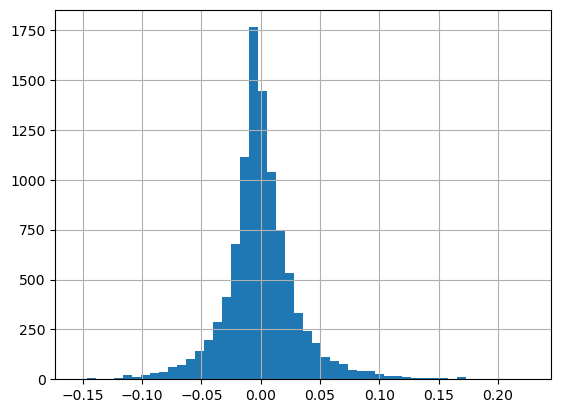

In [12]:
# idf['if'] = (-100.0 / 10000) * idf['influence']
# idf['if'].hist(bins=50)

In [13]:
idf.to_csv('idf-218.csv')

## Train LOO Models

In [18]:
def train_loo_models(
    full_train_dataset,
    test_dataset,
    guids,
    retrain_epochs=3,
    train_from_new=True,
    full_model=None,
):
    loo_losses = []
    
    loo_model, retrain_config = BertClassifier.load_model(
            "model_params/bert-best.yaml"
        )
    retrain_config.update(epochs=retrain_epochs)
    print(json.dumps(retrain_config, indent=4))        
        
    for loo_guid in guids:
        loo_model, retrain_config = BertClassifier.load_model(
            "model_params/bert-best.yaml"
        )
        retrain_config.update(epochs=retrain_epochs)
        
        loo_dataset = create_loo_dataset(full_train_dataset, loo_guid)
        loo_dataloader = DataLoader(
            loo_dataset, batch_size=retrain_config["batch_size"], shuffle=True
        )
        test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

        # if train_from_new:
        #     # Create Bert model
        #     loo_model = BertClassifier.create_bert_classifier(
        #         config["bert_model_name"],
        #         classifier_type=config["classifier_type"],
        #         classifier_hidden_size=config["classifier_hidden_size"],
        #         classifier_drop_out=config["classifier_drop_out"],
        #         classifier_init_state_path=config["classifier_init_state_path"],
        #         freeze_bert=True,
        #     )
        # else:
        #     loo_model = copy.deepcopy(full_model)


        if "optimizer_weight_decay" in retrain_config:
            optimizer = Adam(
                loo_model.classifier.parameters(),
                lr=retrain_config["learning_rate"],
                weight_decay=retrain_config["optimizer_weight_decay"],
            )
        else:
            optimizer = Adam(
                loo_model.classifier.parameters(), lr=retrain_config["learning_rate"]
            )

        run = wandb.init(project="Bert-scratch", config=retrain_config)
        train_utils.train(
            config=retrain_config,
            model=loo_model,
            optimizer=optimizer,
            train_dataloader=loo_dataloader,
            val_dataloader=test_dataloader
        )

        ldf, test_loss, test_acc = train_utils.evaluate_loss(loo_model, test_dataloader)

        wandb.summary["test/loss"] = test_loss
        wandb.summary["test/accuracy"] = test_acc
        wandb.finish()
        # loo_model, ldf, full_test_loss, full_test_acc = train_utils.train_bert_model(
        #     loo_dataset, test_dataset, config
        # )
        ldf["loo_guid"] = loo_guid
        loo_losses.append(ldf)
    ldf = pd.concat(loo_losses, axis=0)
    return ldf

In [19]:
idf.sort_values("influence", ascending=True)

,train_guid,influence,test_guid,if
6668,6668,-22.598194,218,0.225982
7127,7127,-21.497160,218,0.214972
8678,8678,-20.273888,218,0.202739
761,761,-19.895267,218,0.198953
4201,4201,-19.772106,218,0.197721
...,...,...,...,...
1940,1940,14.026974,218,-0.140270
1007,1007,14.182791,218,-0.141828
2030,2030,14.360786,218,-0.143608
9584,9584,14.585812,218,-0.145858


In [14]:
idf.sort_values("influence", ascending=True).iloc[:3].train_guid.to_list()

[9414, 9584, 2030]

In [21]:
# rand_idxs = np.random.randint(low=0, high=len(train_dataset), size=10)
# idf['abs_infl'] = np.abs(idf['influence'])
# Pick most negative
loo_indxs = idf.sort_values("influence", ascending=True).iloc[:3].train_guid.to_list()

ldf = train_loo_models(
    full_train_dataset=train_dataset,
    test_dataset=test_dataset,
    guids=loo_indxs,
    train_from_new=False,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{
    "batch_size": 32,
    "bert_model_name": "distilbert-base-uncased",
    "classifier_drop_out": 0,
    "classifier_hidden_size": 0,
    "classifier_init_state_path": "model_params/bert-epoch9-reg0.001-10000.pt",
    "classifier_type": "single-fc",
    "epochs": 3,
    "learning_rate": 0.0002,
    "max_sequence_length": 64,
    "num_training_examples": 10000,
    "optimizer_weight_decay": 0.001
}


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 16.05batch/s]
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{
    "batch_size": 32,
    "bert_model_name": "distilbert-base-uncased",
    "classifier_drop_out": 0,
    "classifier_hidden_size": 0,
    "classifier_init_state_path": "model_params/bert-epoch9-reg0.001-10000.pt",
    "classifier_type": "single-fc",
    "epochs": 3,
    "learning_rate": 0.0002,
    "max_sequence_length": 64,
    "num_training_examples": 10000,
    "optimizer_weight_decay": 0.001
}


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 16.25batch/s]
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{
    "batch_size": 32,
    "bert_model_name": "distilbert-base-uncased",
    "classifier_drop_out": 0,
    "classifier_hidden_size": 0,
    "classifier_init_state_path": "model_params/bert-epoch9-reg0.001-10000.pt",
    "classifier_type": "single-fc",
    "epochs": 3,
    "learning_rate": 0.0002,
    "max_sequence_length": 64,
    "num_training_examples": 10000,
    "optimizer_weight_decay": 0.001
}


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 16.32batch/s]


## Analysis


In [18]:
# # -- Load Influence Results --
# TRAIN_LENGTH = 10000
# infl_dir = Path("results_10k_strong_l2/influence/")
# infl = pd.read_csv(infl_dir / f"influence-testguid-{TEST_GUID}.csv")
# infl["infl_diff"] = (-100 / TRAIN_LENGTH) * infl["influence"]

In [24]:
# ldf[ldf.test_guid == TEST_GUID]
cdf = ldf[ldf.test_guid == TEST_GUID].copy()

cdf["base_loss"] = fdf[fdf.test_guid == TEST_GUID].loss.squeeze() 
cdf["loss_diff"] = cdf["loss"] - cdf["base_loss"]
cdf = pd.merge(
    cdf,
    idf,
    left_on=["test_guid", "loo_guid"],
    right_on=["test_guid", "train_guid"],
    how="left",
)
cdf["influence"] = (-100.0 / len(train_dataset)) * cdf["influence"]
cdf

,test_guid,logits,pred,label,loss,loo_guid,base_loss,loss_diff,train_guid,influence,if
0,218,"[-2.215192, 1.7946632]",1,0,4.027829,6668,3.820718,0.207111,6668,0.225982,0.225982
1,218,"[-2.227286, 1.8066115]",1,0,4.051448,7127,3.820718,0.230730,7127,0.214972,0.214972
2,218,"[-2.2099252, 1.7896161]",1,0,4.017699,8678,3.820718,0.196981,8678,0.202739,0.202739


           loss_diff  influence
loss_diff   1.000000   0.321345
influence   0.321345   1.000000


<Axes: xlabel='loss_diff', ylabel='influence'>

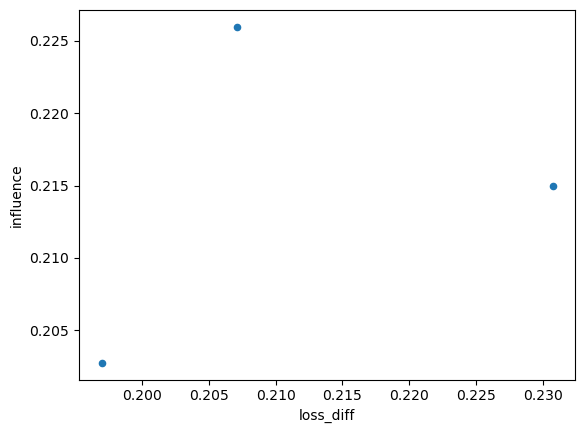

In [25]:
print(cdf[["loss_diff", "influence"]].corr())
cdf[["loss_diff", "influence"]].plot.scatter("loss_diff", "influence")

In [21]:
----

SyntaxError: invalid syntax (2133496677.py, line 1)

In [ ]:
idf_dct = {}

og_model, config = BertClassifier.load_model(
    "model_params/bert-best.yaml"
)

# Create datasets
train_dataset = create_train_sst2(
    num_samples=config["num_training_examples"],
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)

test_dataset = create_test_sst2(
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)


for damping in [1e-3, 5e-3, 8e-3]:
    for depth in [0.3, 0.5, 0.7]:
        og_model, config = BertClassifier.load_model(
            "model_params/bert-best.yaml"
        )
        
        param_infl = list(og_model.classifier.parameters())
        infl = influence.compute_influence(
            full_model=og_model,
            test_guid=TEST_GUID,
            param_influence=param_infl,
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            lissa_r=1,
            lissa_depth=LISSA_DEPTH,
            damping=DAMPING_TERM,
            scale=100,
        )
        idf = create_infl_df(infl, TEST_GUID)
        idf_dct[f"{damping}-{depth}"] = idf                
        

In [ ]:
# ldf[ldf.test_guid == TEST_GUID]
cdf = ldf[ldf.test_guid == TEST_GUID].copy()
cdf["loss_diff"] = cdf["loss"] - fdf[fdf.test_guid == TEST_GUID].loss.squeeze()
cdf = pd.merge(
    cdf,
    idf,
    left_on=["test_guid", "loo_guid"],
    right_on=["test_guid", "train_guid"],
    how="left",
)
cdf["influence"] = (-100.0 / len(train_dataset)) * cdf["influence"]
cdf

In [ ]:
cdf[["loss_diff", "influence"]].corr()

In [ ]:
cdf[["loss_diff", "influence"]].corr("spearman")

In [ ]:
cdf[["loss_diff", "influence"]].plot.scatter("loss_diff", "influence")

In [ ]:
-

In [ ]:
cdf[["loss_diff", "influence"]].plot.scatter("loss_diff", "influence")

In [ ]:
top_infl = idf.sort_values("influence", ascending=False).iloc[:5].train_guid.to_list()
data_utils.get_sentences(top_infl)

In [ ]:
idf.sort_values("influence", ascending=False).iloc[:5]

## Load LOO Results

In [ ]:
loo_results = []
for train_guid in range(len(train_dataset)):
    loss_path = f"loo_2k_l2/run_{train_guid}/test_loss.csv"
    if os.path.exists(loss_path):
        df = pd.read_csv(loss_path)
        df["train_guid"] = train_guid
        loo_results.append(df)
ldf = pd.concat(loo_results)

## Compare

In [ ]:
# ldf = top_ldf

print(fdf[fdf.test_guid == TEST_GUID].loss.squeeze())
cdf = ldf[ldf.test_guid == TEST_GUID].copy()
cdf["loss_diff"] = cdf["loss"] - fdf[fdf.test_guid == TEST_GUID].loss.squeeze()
cdf = pd.merge(
    cdf,
    idf,
    left_on=["test_guid", "loo_guid"],
    right_on=["test_guid", "train_guid"],
    how="left",
)
cdf["influence"] = (-100.0 / len(train_dataset)) * cdf["influence"]
cdf

In [ ]:
cdf[["loss_diff", "influence"]].corr()

In [ ]:
cdf[["loss_diff", "influence"]].corr("spearman")

In [ ]:
cdf[["loss_diff", "influence"]].plot.scatter("loss_diff", "influence")

In [ ]:
-

## Compare Influence with LOO

In [ ]:
TEST_GUID = 218

param_infl = list(og_model.classifier.parameters())
infl = influence.compute_influence(
    full_model=og_model,
    test_guid=TEST_GUID,
    param_influence=param_infl,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    lissa_r=1,
    lissa_depth=0.25,
    damping=8e-3,
    scale=100,
    # training_indices=list(range(15)),
)
idf = pd.DataFrame(data=infl, index=range(len(infl)), columns=["influence"])
idf = idf.rename_axis("train_guid").reset_index()
idf["test_guid"] = TEST_GUID

In [ ]:
-

## Remove Random 10%

In [ ]:
remove_pct = 0.1
remove_length = int(remove_pct * len(train_dataset))

remove_idxs = np.random.randint(low=0, high=len(train_dataset), size=remove_length)
loo_dataset = create_loo_dataset(train_dataset, remove_idxs)

rand_model, rdf, rad_test_loss, rand_test_acc = train_model(
    loo_dataset, test_dataset, config
)

In [ ]:
rdf[rdf.test_guid == TEST_GUID]

## Remove Top 10% Influences

In [ ]:
remove_pct = 0.1
remove_length = int(remove_pct * len(train_dataset))

top_indxs = np.argsort(-infl)[:remove_length]
loo_dataset = create_loo_dataset(train_dataset, top_indxs)

t_model, tdf, top_test_loss, top_test_acc = train_model(
    loo_dataset, test_dataset, config
)

In [ ]:
tdf[tdf.test_guid == TEST_GUID]

## Remove Bottom 10% Influences

In [ ]:
remove_pct = 0.1
remove_length = int(remove_pct * len(train_dataset))

top_indxs = np.argsort(infl)[:remove_length]
loo_dataset = create_loo_dataset(train_dataset, top_indxs)

b_model, bdf, bot_test_loss, bot_test_acc = train_model(
    loo_dataset, test_dataset, config
)

In [ ]:
fdf[fdf.test_guid == TEST_GUID]

In [ ]:
rdf[rdf.test_guid == TEST_GUID]

In [ ]:
tdf[tdf.test_guid == TEST_GUID]

In [ ]:
bdf[bdf.test_guid == TEST_GUID]

In [ ]:
import src.datasets as datasets

datasets.get_test_example(TEST_GUID).sentence.squeeze()

In [ ]:
fdf.sort_values("loss", ascending=False)

In [ ]:
---stop---

## Compare IF and LOO

In [ ]:
fdf[fdf.test_guid == test_guid].loss.squeeze()

In [ ]:
# Load Losses from File
# ldf = pd.read_csv("loo_10k/all_loo_losses.csv")
ldf = pd.concat(loo_dfs, axis=0)

ldf = ldf[ldf.test_guid == test_guid]
ldf["loss_diff"] = ldf["loss"] - fdf[fdf.test_guid == test_guid].loss.squeeze()
ldf["if_diff"] = (-100.0 / len(train_dataset)) * infl[: len(ldf)]
ldf["if_diff2"] = (-1000.0 / len(train_dataset)) * influences[: len(ldf)]
ldf

In [ ]:
print(ldf[["loss_diff", "if_diff", "if_diff2"]].corr())
ldf[["loss_diff", "if_diff"]]

In [ ]:
ldf[["loss_diff", "if_diff"]].plot.scatter("loss_diff", "if_diff")

## Compute Input Influence

In [ ]:
# import src.influence as inf_utils

# test_guid = 560
# param_infl = list(full_model.classifier.parameters())
# infl = inf_utils.compute_input_influence(
#     full_model=full_model,
#     test_guid=test_guid,
#     param_influence=param_infl,
#     train_dataset=train_dataset,
#     test_dataset=test_dataset,
#     lissa_r=1,
#     lissa_depth=0.1,
#     damping=5e-3,
#     scale=100,
#     training_indices=[0],
# )

## Torch Influence

In [ ]:
import copy

from src.torch_influence import BaseObjective
from src.torch_influence.modules import CGInfluenceModule, LiSSAInfluenceModule


class BinClassObjective(BaseObjective):
    def train_outputs(self, model, batch):
        b_guids, b_input_ids, b_attn_mask, b_labels = (t.to(device) for t in batch)
        return model(b_input_ids, b_attn_mask)

    def train_loss_on_outputs(self, outputs, batch):
        b_guids, b_input_ids, b_attn_mask, b_labels = (t.to(device) for t in batch)
        loss_fn = torch.nn.CrossEntropyLoss()
        return loss_fn(outputs, b_labels)

    def train_regularization(self, params):
        return 0

    def test_loss(self, model, params, batch):
        loss_fn = torch.nn.CrossEntropyLoss()

        b_guids, b_input_ids, b_attn_mask, b_labels = (t.to(device) for t in batch)
        outputs = model(b_input_ids, b_attn_mask)

        return loss_fn(outputs, b_labels)


infl_model = BertClassifier.create_bert_classifier(
    config["bert_model_name"],
    classifier_type=config["classifier_type"],
    classifier_hidden_size=config["classifier_hidden_size"],
    classifier_drop_out=config["classifier_drop_out"],
    freeze_bert=True,
    random_state=42,
)
infl_model.load_state_dict(copy.deepcopy(full_model.state_dict()))

module = LiSSAInfluenceModule(
    model=infl_model,
    objective=BinClassObjective(),
    train_loader=DataLoader(train_dataset, batch_size=32),
    test_loader=DataLoader(test_dataset, batch_size=32),
    device=utils.get_device(),
    damp=0.001,
    repeat=1,
    depth=50,
    scale=1e4,
)

all_train_idxs = list(range(len(train_dataset)))
influences = module.influences(all_train_idxs, [test_guid])

In [ ]:
influences[:10]